### Importación de librerías

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms
import statsmodels.api as sm
import joblib

### Carga de datos

In [107]:
df = pd.read_csv('insurance.csv')

### Inspección inicial de datoss  
No hay valores nulos, pero el dataset tiene 3 variables categoricas para transformar

In [108]:
print(df.head(10))
print(df.shape)
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692
(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-

### Transformación de variables  
En sex transformo male en 1 y female en 0  
En smoker transformo yes en 1 y no en 0  
Para region hago un one-hot encoding

In [109]:
df['sex'].replace({'male':1, 'female':0}, inplace=True)
df['smoker'].replace({'yes':1, 'no':0}, inplace=True)
df = pd.get_dummies(df, columns=['region'], dtype=int)

In [110]:
df.describe()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242152,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428546,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000,1.000000


### Analisis de correlaciones  
Las variables que más afectan a la dependiente son smoker, age y bmi  
No hay multicolinealidad entre las variables

In [111]:
df.corr()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.002425,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
region_northeast,0.002475,-0.002425,-0.138156,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


### Outliers y escalado de variables

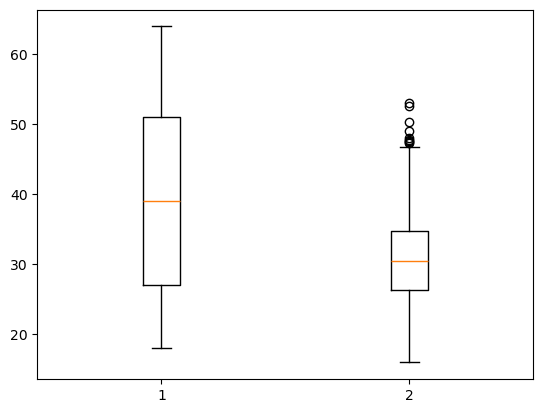

In [112]:
plt.boxplot([df['age'], df['bmi']])
plt.show() #Age no tiene outliers y bmi puede tener alguno que voy a comporbar con z-score

In [113]:
z_scores_bmi = stats.zscore(df['bmi'])
outliers_bmi = df[(z_scores_bmi > 3) | (z_scores_bmi < -3)]
outliers_bmi #Solo hay 4 outliers, que voy a imputar por la mediana

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
116,58,1,49.06,0,0,11381.3254,0,0,1,0
847,23,1,50.38,1,0,2438.0552,0,0,1,0
1047,22,1,52.58,1,1,44501.3982,0,0,1,0
1317,18,1,53.13,0,0,1163.4627,0,0,1,0


In [114]:
mediana_bmi = df['bmi'].median()
df.loc[outliers_bmi.index, 'bmi'] = mediana_bmi

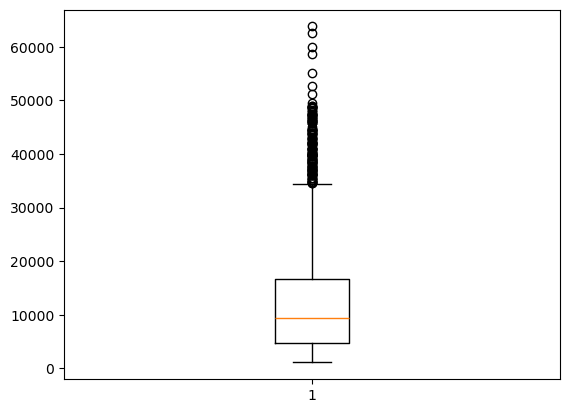

In [115]:
plt.boxplot(df['charges'])
plt.show() #Voy a ver cuantos outliers hay con el mismo método

In [116]:
z_scores_charges = stats.zscore(df['charges'])
outliers_charges = df[(z_scores_charges > 3) | (z_scores_charges < -3)]
outliers_charges.shape #Solo hay 7 outliers, por lo que no voy a tratarlos en la variable dependiente

(7, 10)

In [117]:
scaler = StandardScaler()
df[['age', 'bmi']] = scaler.fit_transform(df[['age', 'bmi']])

### División en conjunto de test y entrenamiento  
Voy a usar validación cruzada, pero quiero valorar las predicciones en un conjunto independiente

In [118]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelo regresión lineal 1  
Con el primer modelo de regresion lineal consigo un r2 medio de 74.68% y de 77.80% en el conjunto de test

In [119]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
r2_promedio = scores.mean()
r2_promedio

0.7467663621623909

In [120]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
r2_test

0.7780947853838006

### Validación del modelo  
Comprobamos la normalidad e independencia de los errores y la homocedasticidad

In [121]:
residuos = y_test - y_pred
dw_stat = durbin_watson(residuos)
print(dw_stat)
shapiro_test = stats.shapiro(residuos)
print(shapiro_test)
X_test_const = sm.add_constant(X_test)
test_bp = sms.het_breuschpagan(residuos, X_test_const)
print(test_bp)

2.1663808564204903
ShapiroResult(statistic=0.9134807586669922, pvalue=2.5108906273607623e-11)
(35.714003148475506, 4.455654345020855e-05, 4.977660589118317, 9.453173824910196e-06)


### Modelo regresión lineal 2
Hay problemas de Heterocedasticidad y de normalidad en los errores, por lo que voy a probar a transformar la variable charges con una transformacion boxcox  
Solo lo uso en train_test_split

In [122]:
df['charges_boxcox'], lambda_optimo = stats.boxcox(df['charges'])
print(f"Valor de lambda en Box-Cox: {lambda_optimo}")

Valor de lambda en Box-Cox: 0.043649053770664956


In [123]:
X = df.drop(['charges', 'charges_boxcox'], axis=1)
y = df['charges']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [124]:
model.fit(X2_train, y2_train)
y2_pred = model.predict(X2_test)
r2_test2 = r2_score(y2_test, y2_pred)
r2_test2

0.8042720543743946

In [125]:
residuos2 = y2_test - y2_pred
dw_stat2 = durbin_watson(residuos2)
print(dw_stat2)
shapiro_test2 = stats.shapiro(residuos2)
print(shapiro_test2)
X_test_const2 = sm.add_constant(X2_test)
test_bp2 = sms.het_breuschpagan(residuos2, X_test_const2)
print(test_bp2)

2.220331059570985
ShapiroResult(statistic=0.8437080383300781, pvalue=9.262055403506334e-16)
(12.748606459640545, 0.17431537232538888, 1.6169789649575501, 0.1200737325249812)


### Modelo regresión lineal 3 (Ridge)  
Se ha solucionado el problema de heterocedasticidad, pero no el de no normalidad de los residuos. Habria que probar en el futuro algun modelo robusto u otro tipo de modelo, pero por ahora voy a probar con Ridge y Lasso  

In [130]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X2_train, y2_train)
y3_pred = ridge_model.predict(X2_test)
r2_test3 = r2_score(y2_test, y3_pred)
r2_test3

0.804143296963758

### Modelo regresión lineal 4 (Lasso)  
Con Ridge no consigo ninguna mejora del modelo, voy a probar con Lasso

In [131]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X2_train, y2_train)
y4_pred = lasso_model.predict(X2_test)
r2_test4 = r2_score(y2_test, y4_pred)
r2_test4

0.7450903421783921

### Guardar el modelo  
Guardo el modelo original de regresión lineal, ya que ninguno consigue una mejora significativa y el modelo con transformacion boxcox sigue teniendo problemas de no normalidad de los residuos.  
Aún así este modelo es bueno para predecir, explicando un 78% de la varianza de la variable dependiente en los datos de test

In [133]:
joblib.dump(model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']